# Zillow Clustering Project
## *Predicting Logerror*

by Kristofer Rivera
2022-04-08

## Project Overview

### Project Description

# Project Description and Goals
In this project, my goals are to determine drivers of error in Zillow home value predictions using data analysis and statistical testing and use this analysis to help build a machine learning model that can predict the error. 

### Project Goals
- Construct an ML Regression model incorporating clustering techniques that predicts logerror for Single Unit Properties that had a transaction in 2017 using attributes of the properties.
- Find key drivers of logerror.
- Make recommendations on what works or doesn't work in predicting logerror.


### Necessary Imports

In [1]:
#Imports for dataframe manipulation 
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for user defined functions
import wrangle as w
import explore as ex

#Imports for preprocessing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.cluster import KMeans

#Imports for modeling and evaluation
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

## Wrangle Zillow Data

I used the following SQL query to acquire the required data from the CodeUp MySQL server:

`SELECT
        prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        landuse.propertylandusedesc,
        story.storydesc,
        construct.typeconstructiondesc
    FROM properties_2017 prop
    JOIN (
        SELECT parcelid, MAX(transactiondate) AS max_transactiondate
        FROM predictions_2017
        GROUP BY parcelid) pred USING(parcelid)
    JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid AND pred.max_transactiondate = predictions_2017.transactiondate
    LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
    LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
    LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
    LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
    LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
    LEFT JOIN storytype story USING (storytypeid)
    LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
    WHERE prop.latitude IS NOT NULL AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31';`. 
        
**Below is an example of the raw data acquired with my sql query (this is before any cleaning or prep):**

In [2]:
#Pre-defined function that gathers my data with a sql query and caches it locally as a csv, 
# Data is read from the csv on future calls of the function
df = w.acquire()
df.head()

Using cached csv...


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


In [3]:
# Summary of my raw data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64
 11  finishedfloor1squarefeet      6023 non-null   float64
 12  calculatedfinishedsquarefeet  77184 non-null  float64
 13  f

**My original raw data frame contained 77380 rows and 68 columns.**

**To clean/prep the data, I did the following:**

1. Renamed columns for clarity and readability.
2. Dropped columns with too many nulls to be useful.
2. Removed outliers that were skewing my data in order to achieve more normal distributions.
3. Changed data types where appropriate for readability or to denote categorical variables. (Floats to ints, ints to strings/objects.)
4. For clearer exploration, I converted the fips column into a county column, replacing the numerical values with the corresponding county names based on information gathered from https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
5. I imputed null values for year_built based on the median year.

**Results:**
- 59962 Rows
- 23 Columns 
  
### Before exploration of variable relationships, I split the data into train, validate, and test data sets.

**Below is an example of what the data looks like after data cleaning and splitting:**

In [4]:
train, validate, test = w.wrangle_zillow()
train.head()

Using cached csv...


,bathrooms,bedrooms,building_quality,home_sqft,fips,latitude,longitude,lot_sqft,regionidcity,regionidcounty,...,year_built,structure_tax_value,assessed_value,land_tax_value,tax_amount,censustractandblock,logerror,heating_system,land_use,county
67577,2.0,2.0,6.0,815.0,6059.0,33747500.0,-117863000.0,7140.0,47568.0,1286.0,...,1989.0,96379.0,167958.0,71579.0,2215.20,60590750022024.0,0.230662,None,Condominium,Orange
5673,2.0,2.0,8.0,1117.0,6037.0,33820500.0,-118342000.0,986080.0,54722.0,3101.0,...,1963.0,30210.0,95425.0,65215.0,1209.14,60376511022012.0,-0.002682,Central,Condominium,Los Angeles
16346,3.0,4.0,6.0,1469.0,6037.0,33805856.0,-118124873.0,6145.0,46298.0,3101.0,...,1952.0,132547.0,443207.0,310660.0,5404.60,60375742012000.0,0.067708,Floor/Wall,Single Family Residential,Los Angeles
24690,3.0,4.0,6.0,2030.0,6059.0,33606164.0,-117670415.0,8662.0,12773.0,1286.0,...,1968.0,168642.0,412426.0,243784.0,4196.14,60590320031009.0,0.002729,None,Single Family Residential,Orange
29587,1.0,2.0,6.0,864.0,6059.0,33844336.0,-117962041.0,7200.0,16764.0,1286.0,...,1948.0,54268.0,444000.0,389732.0,5314.98,60590868022006.0,0.017012,None,Single Family Residential,Orange


- Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data. 
- The validate is used to verify that our models built are not overfit to the train dataset. 
- The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

## Exploratory Analysis ##
**I started exploratory analysis by examning the correlations of all by variables with assessed_value.**

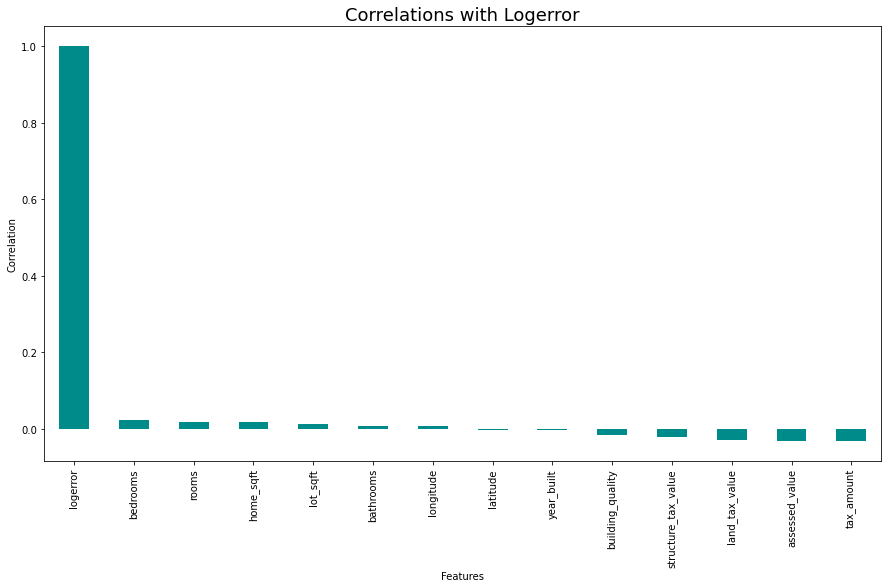

In [14]:
df = train.copy()
ex.plot_correlations(train)

**Takeaways:**
- This gave me a good starting point by showing which variables are most highly correlated with my target: 
    - home_sqft, number of bedrooms, assessed_value and tax_amount are some of the stronger correlations.

**To guide my exploration, I sought to answer these initial questions:**

1. Does logerror differ significantly for properties based on their county?
2. Is the age of the property linearly correlated with logerror?
3. Is home square feet linearly correlated with logerror?
4. Is the number of building quality linearly correlated with logerror?

### Question 1: Does logerror differ significantly for properties based on their county?

#### Los Angeles logerror vs. population logerror? 

$H0$: There is no significant difference between the county logerror and the total population logerror.

$Ha$: There is a signifcant difference between the county logerror and the total population logerror.

In [17]:
# Set up variables for the county logerrors
la = train[train.county == 'Los Angeles']
orange = train[train.county == 'Orange']
ventura = train[train.county == 'Ventura']

In [18]:
# Predefined function that conducts a pearsonr test and prints out the results
ex.pearsonr(train.bedrooms, train.assessed_value)

The correlation value between the two variables is 0.1531 and the P-Value is 1.6610748205816796e-171.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


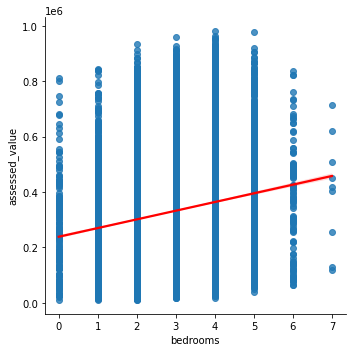

In [7]:
# Create a line plot with regression line to visualize relationship
sns.lmplot(x='bedrooms', y='assessed_value', data=train, line_kws={'color':'red'})
plt.show()

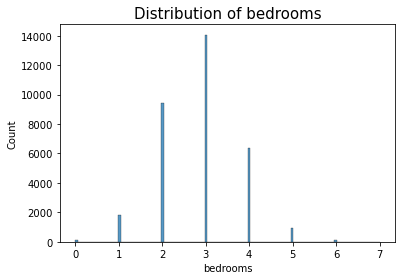

In [8]:
ex.plot_distribution(train, 'bedrooms')

**Takeaway:**
- As would be expected, the more bedrooms a home has the higher it's assessed value. There is a linear correlation.
- Most properties have between three and four bedrooms.

### Question 2:  Is there a linear relationship between a home's number of bathrooms and it's assessed value?

$H0$: The number of bathrooms a home has is not linearly correlated with assessed home value.

$Ha$: The number of bathrooms a home has is linearly correlated with assessed home value.

In [9]:
# Predefined function that conducts a pearsonr test and prints out the results
ex.pearsonr(train.bathrooms, train.assessed_value)

The correlation value between the two variables is 0.3068 and the P-Value is 0.0.
----------------------------------------------------------------------------
Since the P value is less than the alpha, we reject the null hypothesis.


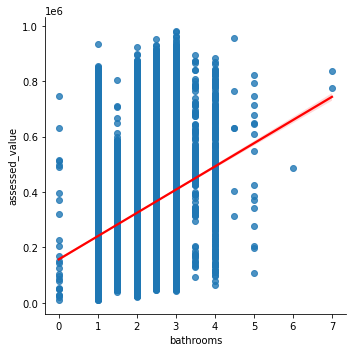

In [10]:
# Create a line plot with regression line to visualize relationship
sns.lmplot(x='bathrooms', y='assessed_value', data=train, line_kws={'color':'red'})
plt.show()

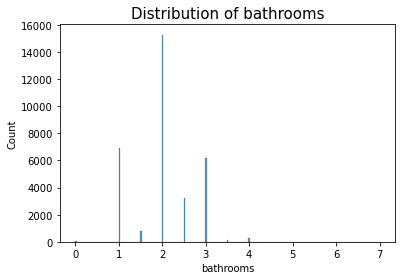

In [11]:
ex.plot_distribution(train, 'bathrooms')

**Takeaways:**
- As would be expected, the more bathrooms a home has the higher it's assessed value. There is a linear correlation.
- Interestingly, the correlation is confimed here to be higher for bathrooms than for bedrooms. 
    - Perhaps this is because homes with more than two bathrooms tend to also have many bedrooms. 

### Question 3: Do homes have higher assessed value based on what county they are in?

$H0$: County location is not correlated with assessed home value.

$Ha$: County location is correlated with assessed home value.

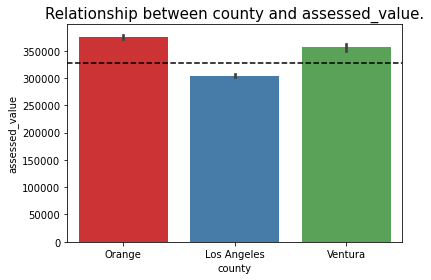

In [12]:
ex.plot_bar(train, 'county', 'assessed_value')

In [13]:
sns.lmplot(x = 'square_feet', y= 'assessed_value', hue='county', data=train, size = 8, palette = 'Set1')
plt.title('Ventura and Orange county homes are valued higher than LA county homes...', fontsize= 20)
plt.show()

KeyError: "['square_feet'] not in index"

### Follow up question: Do homes in Ventura and Orange County have more square feet than homes in LA County?

In [ ]:
ex.plot_bar(train, 'county', 'square_feet')

**Takeaways:**
- Homes in Ventura and Orange county do seem to be valued higher on average than homes in LA county. 
- That said, homes in these counties also have more square footage, which is likely the primary reason for the higher values.

### Question 4: Does the year a home was built (how old it is) affect it's assessed value?

$H0$: The year a home was built is not linearly correlated with assessed home value.

$Ha$: The year a home was built is linearly correlated with assessed home value.

In [ ]:
sns.lmplot(x = 'year_built', y= 'assessed_value', data=train, size = 8, palette = 'Set1', line_kws={'color':'red'})
plt.title('Newer homes are valued higher than older homes', fontsize= 20)
plt.show()

**Takeaway:**
- There is a linear relationship betweent the age of a home and it's assessed value. Newer homes are generally worth more.

## Model and Evaluate

### Preprocessing

**Scale Data**

**Below is a comparison of my variable distributions before and after scaling using a MinMaxScaler:**

In [ ]:
# Visualize scaling of data before actually scaling
wr.visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = ['bedrooms', 'bathrooms', 'square_feet'])

**Since distributions seem to be roughly similar and close to normal I will move forward with the MinMaxScaler.**

In [ ]:
# Scale data using MinMax Scaler
train_scaled, validate_scaled, test_scaled = wr.scale_data_mvp(train, validate, test)

#### Project Stipulation:
"For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product)."

- I will create my X and Y groups accordingly to reach an MVP

In [ ]:
#First Iteration - split into X and Y using scaled data
X_train, y_train = train_scaled.drop(columns=['assessed_value', 'year_built', 'county']), train_scaled.assessed_value
X_validate, y_validate = validate_scaled.drop(columns=['assessed_value', 'year_built', 'county']), validate_scaled.assessed_value
X_test, y_test = test_scaled.drop(columns=['assessed_value', 'year_built', 'county']), test_scaled.assessed_value

#### Calculate our baseline
- Will caculate baseline based on both the mean and median and evaluate which has the lowest RMSE to decide which will be the baseline our model needs to beat.

In [ ]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# Create new data frame to hold my in sample predictions and the same for out of sample
predictions_train = y_train.copy()
predictions_train = predictions_train.rename(columns={'assessed_value':'actual'})
predictions_validate = y_validate.copy()
predictions_validate = predictions_validate.rename(columns={'assessed_value':'actual'})
predictions_test = y_test.copy()
predictions_test = predictions_test.rename(columns={'assessed_value':'actual'})


#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = y_train.assessed_value.mean()
predictions_train['baseline_mean'] = baseline_mean
predictions_validate['baseline_mean'] = baseline_mean
predictions_test['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = y_train.assessed_value.median()
predictions_train['baseline_median'] = baseline_median
predictions_validate['baseline_median'] = baseline_median
predictions_test['baseline_median'] = baseline_median

In [ ]:
# Calculate RMSE based on mean 
mean_rmse = ev.rmse(predictions_train.actual, predictions_train.baseline_mean)

# Calculate RMSE based on median 
median_rmse = ev.rmse(predictions_train.actual, predictions_train.baseline_median)

print("RMSE using Mean as Baseline: ", mean_rmse, 
      "\nRMSE using Median as Baseline: ", median_rmse)

**The lower RMSE indicates a more predictive model so we will use the mean as our baseline.**

## Regression Models - MVP

**For my MVP I trained and fit the 4 models listed here:**

Model 1 - Simple Model (Ordinary Least Squares)

Model 2 - LASSO + LARS

Model 3 - Polynomial Regression

Model 4 - Generalized Linear Model


**These were the evaluation results:**

RMSE using OLS
Train/In-Sample:  216208.36 
Validate/Out-of-Sample:  217786.84

RMSE using LassoLars
Train/In-Sample:  216208.7 
Validate/Out-of-Sample:  217788.65

RMSE using Polynomial Features
Train/In-Sample:  216040.7 
Validate/Out-of-Sample:  217801.43

RMSE using Generalized Linear Model
Train/In-Sample:  216461.09 
Validate/Out-of-Sample:  218190.72

### Below I'll showcase the code for how I built my top 3 models:

### Model 1 - Simple Ordinary Least Squares

In [ ]:
## Model 1 - Simple Model -- Ordinary Least Squares

#Create model
lm = LinearRegression(normalize = True)

#Fit model to train
lm.fit(X_train, y_train)

#Make predictions on test, validate
predictions_train['ols_model'] = lm.predict(X_train)
predictions_validate['ols_model'] = lm.predict(X_validate)

### Model 3 - Polynomial Regression

In [ ]:
## Create the polynomial features

# Create polynomial features
pf = PolynomialFeatures(degree=2)

# fit to my features and create a new version of X_train with transformed features
X_train_poly = pf.fit_transform(X_train)

# Transform features on X_validate and X_test
X_validate_poly = pf.transform(X_validate)
X_test_poly = pf.transform(X_test)

## Create another simple linear regression model

#Create model
lm2 = LinearRegression(normalize=True)

# Fit to training set with polynomial features
lm2.fit(X_train_poly, y_train)

# Make predictions on train and validate
predictions_train['polynomial_model'] = lm2.predict(X_train_poly)
predictions_validate['polynomial_model'] = lm2.predict(X_validate_poly)

### Model 4 - Generalized Linear Model -- TweedieRegressor

In [ ]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to training data
glm.fit(X_train, y_train)

# make predictions on validate
predictions_train['glm'] = glm.predict(X_train)
predictions_validate['glm'] = glm.predict(X_validate)

**All models performed better than the baseline. The Simple OLS Model had the lowest RMSE score for both in-sample and out-of-sample data, so I chose it as my best model.**

### Evaluate Model 1 on Test Data

In [ ]:
#Make predictions on test dataset
predictions_test['ols_test'] = lm.predict(X_test)

# Calculate RMSE
test_rmse = ev.rmse(predictions_test.actual, predictions_test.ols_test)

#Calculate R2 Score
test_r2 = r2_score(predictions_test.actual, predictions_test.ols_test)


print("RMSE using OLS\nTest/Out-of-Sample: ", test_rmse) 

print("R2 Score using OLS\nTest/Out-of-Sample: ", test_r2)     

### Visualize Model Performance

In [ ]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(predictions_test.actual, color='blue', alpha=.5, label="Actual Assessed Value")
plt.hist(predictions_test.ols_test, color='red', alpha=.5, label="Model: Simple OLS Model")
plt.xlabel("Distribution")
plt.ylabel("Assessed Property Value")
plt.title("Comparing the Distribution of Actual Assessed Value to Distributions of Predicted Values for the Top Model")
plt.legend()
plt.show()

In [ ]:
ev.plot_residuals(predictions_test.actual, predictions_test.ols_test, predictions_test)

59962## Conclusions
### I was able to complete my 3 original goals:

**Built a Machine Learning Regression model that predicts property tax assessed values of Single Family Properties that had a transaction in 2017 using attributes of the properties:**
- The simple Ordinary Least Squares Model was my best performing model and beat the baseline model.
- RMSE of model was \\$220,027.11 vs a baseline RMSE of \\$243,610.21
- R2 Score of model was 0.21

**Discovered key drivers of assessed property value:**
- Having more square footage increases the predited value of a property.
- Having more bedrooms and bathrooms increases the predicted value of a property. 
- Location is a driver for assessed property value.
    - Ventura and Orange County properties are valued higher than LA county.
    - They are also larger properties on average which is likely the main driver.
- Home age is a driver of assessed property value. The newer the home the higher the value.

## Recommendations 
- Due to relatively low accuracy of current models, I wouldn't recommend using them for investment purposes unless improvements can be made.
- Based on findings, when building future predictive models I would focus on the square footage, number of bathrooms, and age of properties which were my top 3 drivers.


### Next Steps -- If I had more time I would....
- Conduct feature engineering such as creating a new continuous feature that calculates the age of a property in years using the year_built variable. 
- Investigate my initial questions further -- Example: Determine whether or not county location still increases home value when all other variables are roughly the same.
- Try new models using different paramaters and feature combinations